## Reliability-Based Multi-Objective Optimization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.rnsga3 import RNSGA3
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

In [2]:
# Define the multi-objective optimization problem
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(
            n_var=2,
            n_obj=2,
            n_constr=2,
            xl=np.array([0.1, 0.0]),
            xu=np.array([1.0, 5.0])
        )

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[0]
        f2 = (1 + x[1])/x[0]
        g1 = 9*x[0] + x[1] - 6
        g2 = 9*x[0] - x[1] - 1
        out["F"] = [f1, f2]
        out["G"] = [-g1, -g2]
# Initialize the problem
problem = MyProblem()

In [3]:
# Define the algorithm to use
algorithm = NSGA2(pop_size=200)

# Perform the optimization
res = minimize(
    problem,
    algorithm,
    ('n_gen', 100),
    seed=1,
    verbose=True
)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      200 |      9 |  0.000000E+00 |  1.2624202587 |             - |             -
     2 |      400 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0050791206 |         ideal
     3 |      600 |     22 |  0.000000E+00 |  0.000000E+00 |  0.0252770139 |         ideal
     4 |      800 |     38 |  0.000000E+00 |  0.000000E+00 |  0.0427184083 |         ideal
     5 |     1000 |     47 |  0.000000E+00 |  0.000000E+00 |  0.0078159823 |         ideal
     6 |     1200 |     60 |  0.000000E+00 |  0.000000E+00 |  0.0068859571 |         ideal
     7 |     1400 |     75 |  0.000000E+00 |  0.000000E+00 |  0.0027384273 |         ideal
     8 |     1600 |     80 |  0.000000E+00 |  0.000000E+00 |  0.0397736398 |         nadir
     9 |     1800 |     89 |  0.000000E+00 |  0.000000E+00 |  0.0018461097 |             f
    10 |     2000 |     94 |  0.000000E+00 |  0.000000E+00 |  0.0268647781 |         nadir

    93 |    18600 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0021283936 |             f
    94 |    18800 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0021598569 |             f
    95 |    19000 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0021419628 |             f
    96 |    19200 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0022332829 |             f
    97 |    19400 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0022986675 |             f
    98 |    19600 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0022633011 |             f
    99 |    19800 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0022956352 |             f
   100 |    20000 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0022667454 |             f


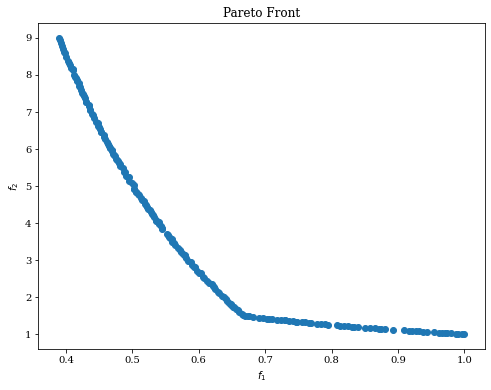

In [4]:
# Extract the Pareto front
pareto_front = res.F
pareto_solutions = res.X
# Visualize the Pareto front
plot = Scatter(title="Pareto Front")
plot.add(pareto_front)
plot.show()

In [5]:
def LSF1(x):
    return (x[0])

def grad_LSF1(x):
    return np.array([9, 1])

def LSF2(x):
    return ((1 + x[1])/x[0])

def grad_LSF2(x):
    return np.array([9, -1])

def transform_to_u(x,mu):
    return (x - mu)/0.03

def transform_to_x(u,mu):
    return 0.03* u + mu     


In [6]:
beta_t = 3

def amv_method1(x,beta_t, max_iter=100, tol=1e-6):
    u_amv = np.zeros(2)
    for k in range(max_iter):
        x_amv = transform_to_x(u_amv,x)
        grad_g = grad_LSF1(x_amv)
        norm_grad_g = np.linalg.norm(grad_g)
        n_u_amv = -grad_g / norm_grad_g
        u_amv_next = beta_t * n_u_amv
        if np.linalg.norm(u_amv_next - u_amv) < tol:
            break
        u_amv = u_amv_next
#                 print(u_amv)
#         print(np.linalg.norm(u_amv))
    return u_amv   

def amv_method2(x,beta_t, max_iter=100, tol=1e-6):
    u_amv = np.zeros(2)
    for k in range(max_iter):
        x_amv = transform_to_x(u_amv,x)
        grad_g = grad_LSF2(x_amv)
        norm_grad_g = np.linalg.norm(grad_g)
        n_u_amv = -grad_g / norm_grad_g
        u_amv_next = beta_t * n_u_amv
        if np.linalg.norm(u_amv_next - u_amv) < tol:
            break
        u_amv = u_amv_next
#                 print(u_amv)
#         print(np.linalg.norm(u_amv))
    return u_amv

In [7]:
beta_t = 3.0
def compute_theta(u_acc, u_acc_next):
    # Compute the angle (theta) between vectors u_acc and u_acc_next
    dot_product = np.dot(u_acc, u_acc_next)
    norms_product = np.linalg.norm(u_acc) * np.linalg.norm(u_acc_next)
    cos_theta = dot_product / norms_product
    theta = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    return theta

def hmv_method(x,beta_t,grad_LSF, max_iter=100, tol=1e-6):
    u_acc = np.zeros(2)  # Initialize u_ACC
    lam_acc = 1.0  # Initial value of lambda_ACC
    C = np.eye(2)  # Identity matrix as the involutory matrix

    for k in range(max_iter):
        x_acc = transform_to_x(u_acc,x)
        grad_g = grad_LSF(x_acc)
        norm_grad_g = np.linalg.norm(grad_g)
        n_hat = -grad_g / norm_grad_g  # n_hat(u_ACC)

        # Update u_ACC
        u_acc_next = beta_t * n_hat

        # Compute theta values
        theta_k_ACC = compute_theta(u_acc, u_acc_next)
        theta_k_minus1_ACC = theta_k_ACC  # Since it's based on the current and next step

        # Update lambda_ACC based on the adaptive rule from the image
        if theta_k_ACC > theta_k_minus1_ACC * 0.2:
            lam_acc = 0.2 * lam_acc
        elif theta_k_ACC <= theta_k_minus1_ACC:
            if theta_k_ACC > 0.2 * theta_k_minus1_ACC:
                lam_acc = lam_acc * theta_k_minus1_ACC / theta_k_ACC
            else:
                lam_acc = lam_acc

        # Check for convergence
        if np.linalg.norm(u_acc_next - u_acc) < tol:
            break

        u_acc = u_acc_next

    return u_acc

## For $\beta$ = 2.0

In [8]:
# Define the multi-objective optimization problem
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(
            n_var=2,
            n_obj=2,
            n_constr=2,
            xl=np.array([0.1, 0.0]),
            xu=np.array([1.0, 5.0])
        )

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[0]
        f2 = (1 + x[1])/x[0]
#         mptp1 = amv_method1(x,beta_t)
#         mptp2 = amv_method2(x,beta_t)
        beta_t = 2.0
        mptp1 = hmv_method(x,beta_t,grad_LSF1)
        mptp2 = hmv_method(x,beta_t,grad_LSF2)
        xt1 = transform_to_x(mptp1,x)
        xt2 = transform_to_x(mptp2,x)
        
        g1 = 9*xt1[0] + xt1[1] - 6
        g2 = 9*xt2[0] - xt2[1] - 1
        
        out["F"] = [f1, f2]
        out["G"] = [-g1, -g2]

# Initialize the problem
problemR1 = MyProblem()

In [9]:
# Define the algorithm to use
algorithm = NSGA2(pop_size=100)

# Perform the optimization
resR1 = minimize(
    problemR1,
    algorithm,
    ('n_gen', 100),
    seed=1,
    verbose=True
)

<ipython-input-7-092faa236694>:6: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = dot_product / norms_product


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      5 |  0.000000E+00 |  1.9797779755 |             - |             -
     2 |      200 |     10 |  0.000000E+00 |  0.000000E+00 |  0.0702402678 |         ideal
     3 |      300 |     19 |  0.000000E+00 |  0.000000E+00 |  0.0435241218 |         ideal
     4 |      400 |     16 |  0.000000E+00 |  0.000000E+00 |  0.0293837840 |             f
     5 |      500 |     21 |  0.000000E+00 |  0.000000E+00 |  0.0177988810 |         ideal
     6 |      600 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0198579224 |         nadir
     7 |      700 |     33 |  0.000000E+00 |  0.000000E+00 |  0.0229443788 |         ideal
     8 |      800 |     39 |  0.000000E+00 |  0.000000E+00 |  0.0045538922 |             f
     9 |      900 |     48 |  0.000000E+00 |  0.000000E+00 |  0.0089425099 |             f
    10 |     1000 |     60 |  0.000000E+00 |  0.000000E+00 |  0.0211348565 |         nadir

    93 |     9300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0019834697 |             f
    94 |     9400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0022198936 |             f
    95 |     9500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0024698123 |             f
    96 |     9600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0024715082 |             f
    97 |     9700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0028026214 |             f
    98 |     9800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0005084136 |             f
    99 |     9900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0011510378 |             f
   100 |    10000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0015617658 |             f


## For $\beta$ = 3.0

In [10]:
# Define the multi-objective optimization problem
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(
            n_var=2,
            n_obj=2,
            n_constr=2,
            xl=np.array([0.1, 0.0]),
            xu=np.array([1.0, 5.0])
        )

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[0]
        f2 = (1 + x[1])/x[0]
#         mptp1 = amv_method1(x,beta_t)
#         mptp2 = amv_method2(x,beta_t)
        beta_t = 3.0
        mptp1 = hmv_method(x,beta_t,grad_LSF1)
        mptp2 = hmv_method(x,beta_t,grad_LSF2)
        xt1 = transform_to_x(mptp1,x)
        xt2 = transform_to_x(mptp2,x)
        
        g1 = 9*xt1[0] + xt1[1] - 6
        g2 = 9*xt2[0] - xt2[1] - 1
        
        out["F"] = [f1, f2]
        out["G"] = [-g1, -g2]

# Initialize the problem
problemR2 = MyProblem()

In [11]:
# Define the algorithm to use
algorithm = NSGA2(pop_size=100)

# Perform the optimization
resR2 = minimize(
    problemR2,
    algorithm,
    ('n_gen', 100),
    seed=1,
    verbose=True
)

<ipython-input-7-092faa236694>:6: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = dot_product / norms_product


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      4 |  0.000000E+00 |  2.2428903232 |             - |             -
     2 |      200 |     10 |  0.000000E+00 |  0.0003931496 |  0.1196593555 |         ideal
     3 |      300 |     16 |  0.000000E+00 |  0.000000E+00 |  0.0224725734 |         ideal
     4 |      400 |     22 |  0.000000E+00 |  0.000000E+00 |  0.0493549129 |         ideal
     5 |      500 |     23 |  0.000000E+00 |  0.000000E+00 |  0.0442370710 |         nadir
     6 |      600 |     23 |  0.000000E+00 |  0.000000E+00 |  0.0212250346 |         ideal
     7 |      700 |     34 |  0.000000E+00 |  0.000000E+00 |  0.0353735427 |         ideal
     8 |      800 |     40 |  0.000000E+00 |  0.000000E+00 |  0.0235705485 |         ideal
     9 |      900 |     51 |  0.000000E+00 |  0.000000E+00 |  0.0055187853 |         ideal
    10 |     1000 |     54 |  0.000000E+00 |  0.000000E+00 |  0.0554786170 |         ideal

    92 |     9200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0020071478 |             f
    93 |     9300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0022236971 |             f
    94 |     9400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0022256860 |             f
    95 |     9500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0022446747 |             f
    96 |     9600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0021316896 |             f
    97 |     9700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0021018592 |             f
    98 |     9800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0021420441 |             f
    99 |     9900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0022053963 |             f
   100 |    10000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0023450270 |             f


## For $\beta$ = 4.0

In [12]:
# Define the multi-objective optimization problem
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(
            n_var=2,
            n_obj=2,
            n_constr=2,
            xl=np.array([0.1, 0.0]),
            xu=np.array([1.0, 5.0])
        )

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[0]
        f2 = (1 + x[1])/x[0]
#         mptp1 = amv_method1(x,beta_t)
#         mptp2 = amv_method2(x,beta_t)
        beta_t = 4.0
        mptp1 = hmv_method(x,beta_t,grad_LSF1)
        mptp2 = hmv_method(x,beta_t,grad_LSF2)
        xt1 = transform_to_x(mptp1,x)
        xt2 = transform_to_x(mptp2,x)
        
        g1 = 9*xt1[0] + xt1[1] - 6
        g2 = 9*xt2[0] - xt2[1] - 1
        
        out["F"] = [f1, f2]
        out["G"] = [-g1, -g2]

# Initialize the problem
problemR3 = MyProblem()

In [13]:
# Define the algorithm to use
algorithm = NSGA2(pop_size=100)

# Perform the optimization
resR3 = minimize(
    problemR3,
    algorithm,
    ('n_gen', 100),
    seed=1,
    verbose=True
)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      4 |  0.000000E+00 |  2.5216507297 |             - |             -


<ipython-input-7-092faa236694>:6: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = dot_product / norms_product


     2 |      200 |      7 |  0.000000E+00 |  0.0193360643 |  0.0828257443 |         ideal
     3 |      300 |     15 |  0.000000E+00 |  0.000000E+00 |  0.0983623564 |         ideal
     4 |      400 |     16 |  0.000000E+00 |  0.000000E+00 |  0.0538958773 |         ideal
     5 |      500 |     24 |  0.000000E+00 |  0.000000E+00 |  0.0203184916 |             f
     6 |      600 |     30 |  0.000000E+00 |  0.000000E+00 |  0.0119745779 |             f
     7 |      700 |     37 |  0.000000E+00 |  0.000000E+00 |  0.0715439997 |         ideal
     8 |      800 |     42 |  0.000000E+00 |  0.000000E+00 |  0.0110577191 |         ideal
     9 |      900 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0043169508 |             f
    10 |     1000 |     60 |  0.000000E+00 |  0.000000E+00 |  0.0056907837 |         ideal
    11 |     1100 |     69 |  0.000000E+00 |  0.000000E+00 |  0.0042228604 |         ideal
    12 |     1200 |     77 |  0.000000E+00 |  0.000000E+00 |  0.0607991472 |         ideal

    94 |     9400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0012867993 |             f
    95 |     9500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0013238256 |             f
    96 |     9600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0013987104 |             f
    97 |     9700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0014426763 |             f
    98 |     9800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0014402845 |             f
    99 |     9900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0016814539 |             f
   100 |    10000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0018681622 |             f


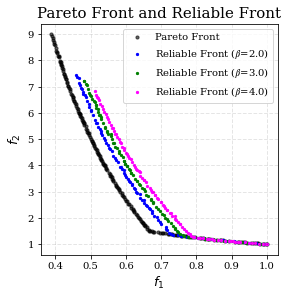

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4.25, 4.25))
plt.scatter(res.F[:, 0], res.F[:, 1], s=10, label='Pareto Front', color='black', alpha=0.6)
plt.scatter(resR1.F[:, 0], resR1.F[:, 1], s=5, label='Reliable Front ($𝛽$=2.0)', color='blue', alpha=1.0)
plt.scatter(resR2.F[:, 0], resR2.F[:, 1], s=5, label='Reliable Front ($𝛽$=3.0)', color='green', alpha=1.0)
plt.scatter(resR3.F[:, 0], resR3.F[:, 1], s=5, label='Reliable Front ($𝛽$=4.0)', color='magenta', alpha=1.0)
plt.xlabel('$f_1$',fontsize=13)
plt.ylabel('$f_2$',fontsize=13)
plt.title('Pareto Front and Reliable Front',fontsize=15)
plt.legend()
plt.grid(color='k', linestyle='--', linewidth=1, alpha=0.1)
# plt.savefig("Bench2_RF.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Effect of $\beta$ on constraints

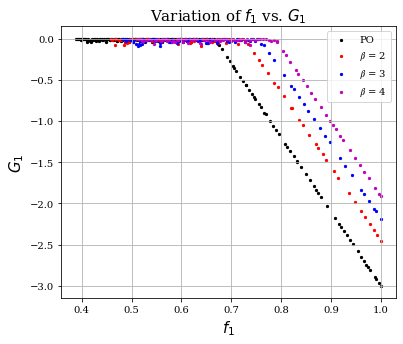

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 5))
plt.scatter(res.F[:, 0], res.G[:, 0], s=5, label='PO', color='black', alpha=1)
plt.scatter(resR1.F[:, 0], resR1.G[:, 0], s=5, label='$𝛽$ = 2', color='r', alpha=1)
plt.scatter(resR2.F[:, 0], resR2.G[:, 0], s=5, label='$𝛽$ = 3', color='b', alpha=1)
plt.scatter(resR3.F[:, 0], resR3.G[:, 0], s=5, label='$𝛽$ = 4', color='m', alpha=1)

plt.xlabel('$f_1$',fontsize=15)
plt.ylabel('$G_1$',fontsize=15)
plt.title('Variation of $f_1$ vs. $G_1$',fontsize=15)
plt.legend()
plt.grid(True)
plt.show()

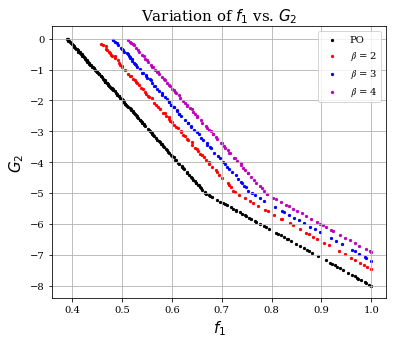

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 5))
plt.scatter(res.F[:, 0], res.G[:, 1], s=5, label='PO', color='black', alpha=1)
plt.scatter(resR1.F[:, 0], resR1.G[:, 1], s=5, label='$𝛽$ = 2', color='r', alpha=1)
plt.scatter(resR2.F[:, 0], resR2.G[:, 1], s=5, label='$𝛽$ = 3', color='b', alpha=1)
plt.scatter(resR3.F[:, 0], resR3.G[:, 1], s=5, label='$𝛽$ = 4', color='m', alpha=1)

plt.xlabel('$f_1$',fontsize=15)
plt.ylabel('$G_2$',fontsize=15)
plt.title('Variation of $f_1$ vs. $G_2$',fontsize=15)
plt.legend()
plt.grid(True)
plt.show()

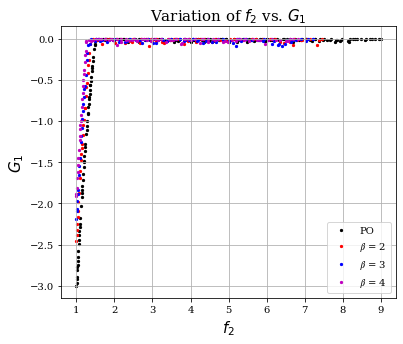

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 5))
plt.scatter(res.F[:, 1], res.G[:, 0], s=5, label='PO', color='black', alpha=1)
plt.scatter(resR1.F[:, 1], resR1.G[:, 0], s=5, label='$𝛽$ = 2', color='r', alpha=1)
plt.scatter(resR2.F[:, 1], resR2.G[:, 0], s=5, label='$𝛽$ = 3', color='b', alpha=1)
plt.scatter(resR3.F[:, 1], resR3.G[:, 0], s=5, label='$𝛽$ = 4', color='m', alpha=1)

plt.xlabel('$f_2$',fontsize=15)
plt.ylabel('$G_1$',fontsize=15)
plt.title('Variation of $f_2$ vs. $G_1$',fontsize=15)
plt.legend()
plt.grid(True)
plt.show()

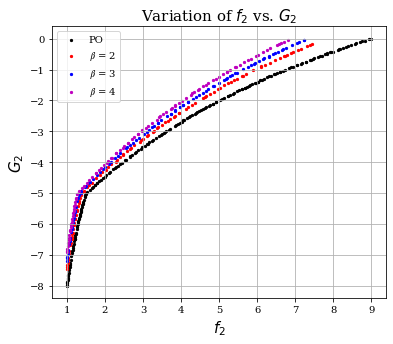

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 5))
plt.scatter(res.F[:, 1], res.G[:, 1], s=5, label='PO', color='black', alpha=1)
plt.scatter(resR1.F[:, 1], resR1.G[:, 1], s=5, label='$𝛽$ = 2', color='r', alpha=1)
plt.scatter(resR2.F[:, 1], resR2.G[:, 1], s=5, label='$𝛽$ = 3', color='b', alpha=1)
plt.scatter(resR3.F[:, 1], resR3.G[:, 1], s=5, label='$𝛽$ = 4', color='m', alpha=1)

plt.xlabel('$f_2$',fontsize=15)
plt.ylabel('$G_2$',fontsize=15)
plt.title('Variation of $f_2$ vs. $G_2$',fontsize=15)
plt.legend()
plt.grid(True)
plt.show()

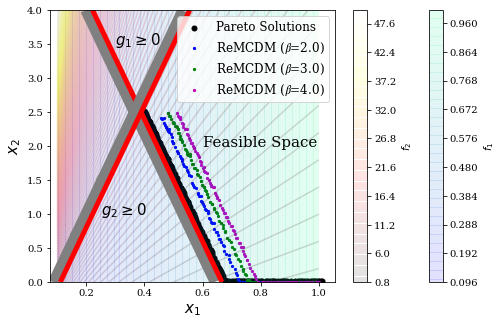

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Define the functions
def f1(x, y):
    return x

def f2(x, y):
    return (1+y)/x

def g1(x, y):
    return y + 9*x - 6

def g2(x, y):
    return -y + 9*x - 1

# Create a grid of points
x = np.linspace(0.1, 1, 400)
y = np.linspace(0, 4, 400)
X, Y = np.meshgrid(x, y)

# Evaluate the functions on the grid
Z1 = f1(X, Y)
Z2 = f2(X, Y)
G1 = g1(X, Y)
G2 = g2(X, Y)

# Plot the contour plots
plt.figure(figsize=(8, 5))
cp1 = plt.contour(X, Y, Z1, levels=150, cmap='winter', alpha = 0.15)
cp2 = plt.contour(X, Y, Z2, levels=150, cmap='hot', alpha = 0.15)
plt.contour(X-0.025, Y, G1, levels=[0], colors='gray', linewidths=10)  # Constraint
plt.contour(X, Y, G1, levels=[0], colors='r', linewidths=5)  # Constraint
plt.contour(X-0.025, Y, G2, levels=[0], colors='gray', linewidths=10)  # Constraint
plt.contour(X, Y, G2, levels=[0], colors='r', linewidths=5)  # Constraint
plt.scatter(res.X[:,0]+0.01, res.X[:,1]+0.01, s=25, color='k')
plt.scatter(resR1.X[:,0], resR1.X[:,1], s=5, color='b')
plt.scatter(resR2.X[:,0], resR2.X[:,1], s=5, color='g')
plt.scatter(resR3.X[:,0], resR3.X[:,1], s=5, color='m')
plt.legend(["Pareto Solutions", "ReMCDM ($𝛽$=2.0)","ReMCDM ($𝛽$=3.0)","ReMCDM ($𝛽$=4.0)"], loc ="upper right",fontsize=12)
# Add colorbars and labels
# plt.clabel(cp1, inline=True, fontsize=8)
# plt.clabel(cp2, inline=True, fontsize=8)
plt.text(0.30, 3.5, "$g_1\geq0$", fontsize=15)
plt.text(0.25, 1.0, "$g_2\geq0$", fontsize=15)
plt.text(0.6, 2.0, "Feasible Space", fontsize=15)
plt.colorbar(cp1, label='$f_1$')
plt.colorbar(cp2, label='$f_2$')
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
# plt.title('Contour plots of $f_1$ and $f_2$ with constraint $g_1$ and $g_2$')
# plt.savefig("Bench2_Soln.pdf", format="pdf", bbox_inches="tight")
# Show the plot
plt.show()


## ReMCDM Using R-NSGA-III ($\beta$ = 3.0)

In [20]:
# Define reference points
ref_points = np.array([[0.9, 6],[0.6, 8]])

# Get Algorithm
algorithm = RNSGA3(
    ref_points=ref_points,
    pop_per_ref_point=20,
    mu=0.1)

In [21]:
res_RNS3 = minimize(problemR2,
               algorithm=algorithm,
               termination=('n_gen', 200),
               seed=1,
               verbose=True)

<ipython-input-7-092faa236694>:6: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = dot_product / norms_product
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       42 |      4 |  0.000000E+00 |  2.2873595788 |             - |             -
     2 |       84 |      4 |  0.000000E+00 |  0.000000E+00 |  0.2520152574 |         ideal
     3 |      126 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0102056600 |         ideal
     4 |      168 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0716776455 |         ideal
     5 |      210 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0744462918 |             f
     6 |      252 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     7 |      294 |      4 |  0.000000E+00 |  0.000000E+00 |  0.1000077546 |         ideal
     8 |      336 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0819009257 |             f
     9 |      378 |     10 |  0.000000E+00 |  0.000000E+00 |  0.0231662620 |             f
    10 |      420 |      9 |  0.000000E+00 |  0.000000E+00 |  0.0248482928 |         ideal

    95 |     3990 |     33 |  0.000000E+00 |  0.000000E+00 |  0.0005108543 |             f
    96 |     4032 |     33 |  0.000000E+00 |  0.000000E+00 |  0.0005426567 |             f
    97 |     4074 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0061371957 |         ideal
    98 |     4116 |     29 |  0.000000E+00 |  0.000000E+00 |  0.0001045653 |             f
    99 |     4158 |     29 |  0.000000E+00 |  0.000000E+00 |  0.0001732253 |             f
   100 |     4200 |     30 |  0.000000E+00 |  0.000000E+00 |  0.0006393666 |             f
   101 |     4242 |     29 |  0.000000E+00 |  0.000000E+00 |  0.0005800673 |             f
   102 |     4284 |     30 |  0.000000E+00 |  0.000000E+00 |  0.0007335960 |             f
   103 |     4326 |     30 |  0.000000E+00 |  0.000000E+00 |  0.0007395733 |             f
   104 |     4368 |     30 |  0.000000E+00 |  0.000000E+00 |  0.0007563816 |             f
   105 |     4410 |     31 |  0.000000E+00 |  0.000000E+00 |  0.0007892992 |             f

   193 |     8106 |     38 |  0.000000E+00 |  0.000000E+00 |  0.0019577229 |             f
   194 |     8148 |     39 |  0.000000E+00 |  0.000000E+00 |  0.0019384717 |             f
   195 |     8190 |     39 |  0.000000E+00 |  0.000000E+00 |  0.0019830811 |             f
   196 |     8232 |     39 |  0.000000E+00 |  0.000000E+00 |  0.0020027665 |             f
   197 |     8274 |     39 |  0.000000E+00 |  0.000000E+00 |  0.0019943162 |             f
   198 |     8316 |     40 |  0.000000E+00 |  0.000000E+00 |  0.0020081151 |             f
   199 |     8358 |     40 |  0.000000E+00 |  0.000000E+00 |  0.0020081151 |             f
   200 |     8400 |     40 |  0.000000E+00 |  0.000000E+00 |  0.0019981134 |             f


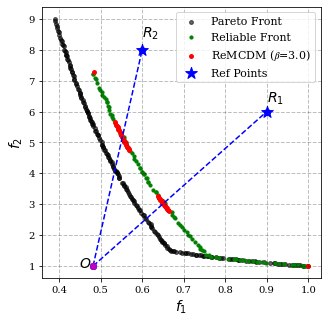

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.scatter(res.F[:, 0], res.F[:, 1], s=15, label='Pareto Front', color='black', alpha=0.6)
plt.scatter(resR2.F[:, 0], resR2.F[:, 1], s=10, label='Reliable Front (RI=3.0)', color='green', alpha=1.0)
plt.scatter(res_RNS3.F[:, 0], res_RNS3.F[:, 1], s=15, label='ReMCDM (RI=4.0)', color='red', alpha=1.0)
plt.scatter(ref_points[:, 0], ref_points[:, 1], s=150,  marker='*', facecolors='b', edgecolors='b')
plt.legend(["Pareto Front", "Reliable Front", "ReMCDM ($𝛽$=3.0)", "Ref Points"], loc ="upper right",fontsize=11)

ideal_point = [min(resR2.F[:, 0]), min(resR2.F[:, 1])] 
plt.plot([ideal_point[0], ref_points[0,0]], [ideal_point[1], ref_points[0,1]], 'bo', linestyle="--")
plt.plot([ideal_point[0], ref_points[1,0]], [ideal_point[1], ref_points[1,1]], 'bo', linestyle="--")
plt.plot([ideal_point[0]], [ideal_point[1]], 'mo', linestyle="--")
plt.text(1.0*ref_points[0,0], 1.05*ref_points[0,1], "$R_1$", fontsize=14)
plt.text(1.0*ref_points[1,0], 1.05*ref_points[1,1], "$R_2$", fontsize=14)
plt.text(0.93*ideal_point[0],  0.95*ideal_point[1], "$O$", fontsize=14)

plt.xlabel('$f_1$',fontsize=14)
plt.ylabel('$f_2$',fontsize=14)
plt.grid(color='k', linestyle='--', linewidth=1, alpha=0.25)
# plt.savefig("Bench2_ReMCDM.pdf", format="pdf", bbox_inches="tight")